### Performance comparison of SLS and LQR controllers with bound constraints on the control commands

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from copy import deepcopy
from time import time
from isls import SLS
from isls.utils import get_double_integrator_AB

from isls.projections import *

%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.style.use("default")
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.5
np.set_printoptions(precision=5, suppress=False)
plt.rcParams["figure.figsize"] = (4,3)
real_min = np.finfo(float).tiny

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Problem setup

In [39]:
x_dim = 1
u_dim = 1
T = 1.
horizon = 100
nb_deriv = 2
N = horizon
dt = T/horizon
print("dt:", dt)
d = x_dim*nb_deriv
A, B = get_double_integrator_AB(x_dim, nb_deriv=nb_deriv, dt=dt)

dt: 0.01


In [19]:
%%time
sls = SLS(d, u_dim, horizon)
sls.AB = [A,B]

Wall time: 23 ms


Define the task:

In [20]:
u_std=1e-2
x_final_target = np.array([1., 0.])
viaQ_final = np.diag([1e6, 1e6])

free_state = np.zeros(d)
viaQ_free = np.diag([0]*d)

zs = np.stack([free_state,  x_final_target])
Qs = np.stack([viaQ_free,  viaQ_final])


seq = np.zeros(N, dtype=np.int32)
seq[N-1] = 1

sls.set_quadratic_cost(zs, Qs, seq, u_std)

In [21]:
x0 = np.zeros(d)
x_opt, u_opt = sls.solve(x0, method="batch")

MAX control:  6.06051888764695
Last position:  0.9999876316133441
Last velocity:  6.122356028259723e-06


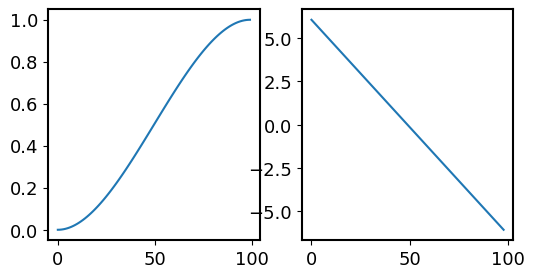

In [22]:
x0 = np.zeros(d)
fig,ax = plt.subplots(ncols=2, figsize=(6,3))
ax[1].plot(u_opt[:-1])
ax[0].plot(x_opt[:,0])

print("MAX control: ", np.max(u_opt))
print("Last position: ", x_opt[-1,0])
print("Last velocity: ", x_opt[-1,1])

## ADMM Optimization with control bounds

### Batch Solution

ADMM converged at iteration  19 !
ADMM residual is  8.10e-05 6.63e-05
5.000018035934772
-5.000018035843368
cost is 1.250e+01
cost is 1.237e+01
Wall time: 51 ms


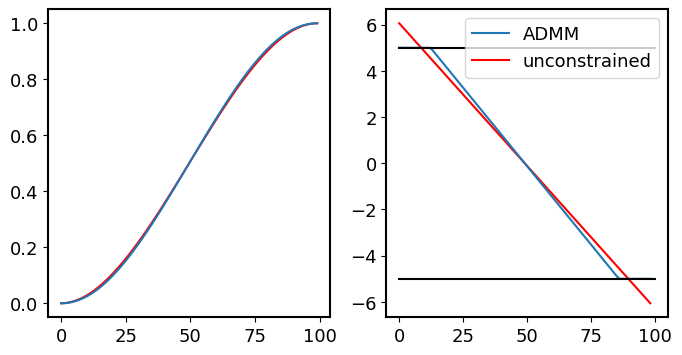

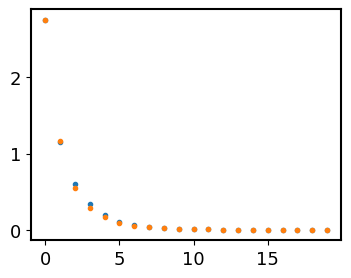

In [31]:
%%time
lower_u = -5.
upper_u = 5.
max_iter = 100

x_optimal, u_optimal, log = sls.ADMM_LQT_Batch(x0=np.zeros(d), project_u=lambda u: project_bound(u, lower_u, upper_u), max_iter=max_iter, 
                                      rho_u=1e-2,tol=1e-4, verbose=1, log=True)

print(np.max(u_optimal))
print(np.min(u_optimal))
fig,ax = plt.subplots(ncols=2, figsize=(8,4))
x_optimal = sls.Sw[:,:d]@x0 + sls.Su@u_optimal
ax[0].plot(x_optimal.reshape(N,-1)[:,0], label="ADMM")
ax[0].plot(x_opt[:,0], "r", label="unconstrained", zorder=1)


ax[1].plot(u_optimal.reshape(N,-1)[:-1], label="ADMM")
ax[1].plot(u_opt[:-1], "r", label="unconstrained", zorder=1)
ax[1].plot([0,N*u_dim],[lower]*2, "k")
ax[1].plot([0,N*u_dim],[upper]*2, "k")

plt.legend()
print("cost is", "{:.3e}".format(sls.compute_cost(x_optimal, u_optimal)))
print("cost is", "{:.3e}".format(sls.compute_cost(x_opt, u_opt)))
plt.figure()
plt.plot(log,".")

### DP solution

cost is 1.250e+01
cost is 1.237e+01
Wall time: 172 ms


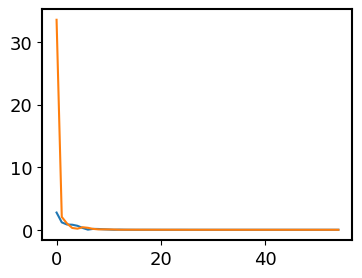

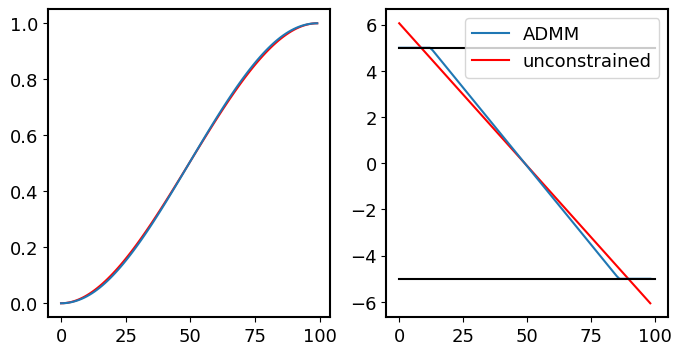

In [32]:
%%time
x0 = np.zeros(d)
rho_u = 1e-1
x_optimal, u_optimal, K_optimal, k_optimal, log_DP = sls.ADMM_LQT_DP(np.zeros(d), project_u=lambda u: project_bound(u, lower_u, upper_u),max_iter=500, 
                                      rho_u=rho_u, tol=1e-4, verbose=False, log=True)
plt.plot(log_DP)
fig,ax = plt.subplots(ncols=2, figsize=(8,4))
x_optimal = sls.Sw[:,:d]@x0 + sls.Su@u_optimal
ax[0].plot(x_optimal.reshape(N,-1)[:,0], label="ADMM")
ax[0].plot(x_opt[:,0], "r", label="unconstrained", zorder=1)


ax[1].plot(u_optimal.reshape(N,-1)[:-1], label="ADMM")
ax[1].plot(u_opt[:-1], "r", label="unconstrained", zorder=1)
ax[1].plot([0,N*u_dim],[lower]*2, "k")
ax[1].plot([0,N*u_dim],[upper]*2, "k")

plt.legend()
print("cost is", "{:.3e}".format(sls.compute_cost(x_optimal, u_optimal)))
print("cost is", "{:.3e}".format(sls.compute_cost(x_opt, u_opt)))

### Robust optimal control with system level synthesis

In [33]:
from scipy.stats import norm

# For robust constraints only for x0's position, z has dim 1+x_dim
x0_pos = np.zeros(x_dim)
mu = np.zeros(x_dim + 1) # [1, x0]
mu[0] = 1. 
mu[1:] = x0_pos

var_x0 = 0.01
sigma = np.zeros(x_dim + 1)
sigma[0] = 0. # first term is deterministic and equal to one.
sigma[1:] = var_x0 # variance for the x0
psi_inv = norm.ppf(0.95)
# psi_inv = norm.ppf(0.5)+1e-100 # should be the same as expected
 
Au = np.diag(np.sqrt(sigma))
bu = np.zeros(Au.shape[0])
cu = -mu/psi_inv
du = upper_u/psi_inv

Al = Au
bl = bu
cl = mu/psi_inv
dl = -lower_u/psi_inv

As = [Au, Al]
bs = [bu, bl]
cs = [cu, cl]
ds = [du, dl]


nb_proj = 2 # nb of projections needed for each row of psi_u

A_ = [np.concatenate([As[i] ,cs[i][None]], axis=0) for i in range(nb_proj)]
b_ = [np.append(bs[i], ds[i]) for i in range(nb_proj)]

project_u = lambda y: project_set_convex(y, A_, b_, projections=[project_soc_unit]*nb_proj, rho=1e1, max_iter=100, threshold=1e-3)

Start iterating..
ADMM can't improve anymore at iteration  25 !
ADMM residual is  8.50e-13 3.77e-01
ADMM residual change is  3.37e-03 1.00e-04
cost is 1.90e-04
cost is 1.90e-04
Wall time: 207 ms


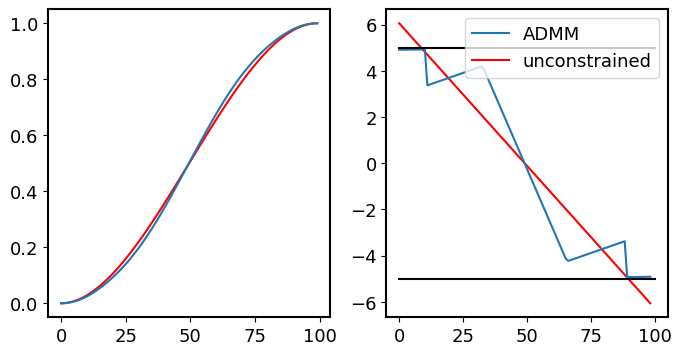

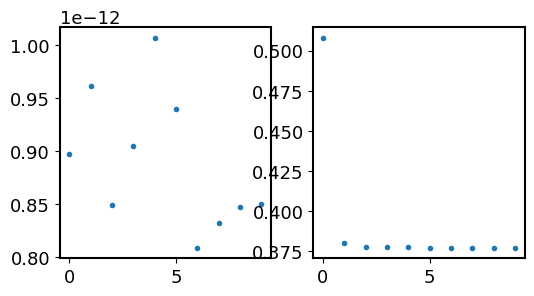

In [34]:
%%time
x0 = np.zeros(d)
max_iter = 50
rho_u = 1e2
alpha = 1.
du, PHI_U, log = sls.ADMM_SLS(project_u = project_u, max_iter=max_iter, rho_u=rho_u, alpha=alpha, tol=1e-3, verbose=1, log=True)

u_optimal = du.copy()
fig,ax = plt.subplots(ncols=2, figsize=(8,4))
x_optimal = sls.Sw[:,:d]@x0 + sls.Su@u_optimal
ax[0].plot(x_optimal.reshape(N,-1)[:,0], label="ADMM")
ax[0].plot(x_opt[:,0], "r", label="unconstrained", zorder=1)


ax[1].plot(u_optimal.reshape(N,-1)[:-1], label="ADMM")
ax[1].plot(u_opt[:-1], "r", label="unconstrained", zorder=1)
ax[1].plot([0,N*u_dim],[lower]*2, "k")
ax[1].plot([0,N*u_dim],[upper]*2, "k")

plt.legend()
print("cost is", "{:.2e}".format(sls.compute_cost(x_optimal)))
print("cost is", "{:.2e}".format(sls.compute_cost(x_opt)))
fig,ax= plt.subplots(ncols=2, figsize=(6,3))
ax[0].plot(np.stack(log)[-10:,0], ".")
ax[1].plot(np.stack(log)[-10:,1], ".")

### Experiment 1: Run 10000 experiments starting from different initial positions  

When we look at the statistics of success, we expect a success of at least $\alpha$ percent, where $\alpha$ is the chosen probability of robustness.

In [35]:
noise_scale = 0.0
scale_x0 = np.sqrt(var_x0)
nb_experiments = 10000

x_logs = np.zeros((2, nb_experiments, N,  x_dim*nb_deriv))
u_logs = np.zeros((2, nb_experiments, N,  u_dim))

x0s = np.zeros((nb_experiments, d))
x0s[:, :x_dim] = np.random.normal(loc=np.zeros(x_dim), scale=scale_x0, size=(nb_experiments, x_dim))

x_logs[0], u_logs[0] = sls.get_trajectory_dp(x0s, K_optimal, k_optimal, noise_scale=noise_scale)

K_sls, k_sls = sls.controller(PHI_U, du)
x_logs[1], u_logs[1] = sls.get_trajectory_sls(x0s, K_sls, k_sls, noise_scale=noise_scale)

In [36]:
thr = 1e-3
names = ["DP", "SLS"]
for i in range(2):
    su = np.all(lower_u - thr <= u_logs[i,:,:,:], axis=(1,2))
    su = su * np.all(u_logs[i,:,:,:] <= upper_u + thr, axis=(1,2))
    print("Percentage of success for", names[i], 100*np.sum(su)/nb_experiments)

Percentage of success for DP 50.18
Percentage of success for SLS 96.07


### Experiment 1: Compare DP solution (non-robust) and SLS solution (robust)

In [37]:
noise_scale = 0.0
scale_x0 = np.sqrt(var_x0)
nb_experiments = 5

x_logs = np.zeros((2, nb_experiments, N,  x_dim*nb_deriv))
u_logs = np.zeros((2, nb_experiments, N,  u_dim))

x0s = np.zeros((nb_experiments, d))
x0s[:, :x_dim] = np.random.normal(loc=np.zeros(x_dim), scale=scale_x0, size=(nb_experiments, x_dim))

x_logs[0], u_logs[0] = sls.get_trajectory_dp(x0s, K_optimal, k_optimal, noise_scale=noise_scale)

K_sls, k_sls = sls.controller(PHI_U, du)
x_logs[1], u_logs[1] = sls.get_trajectory_sls(x0s, K_sls, k_sls, noise_scale=noise_scale)

thr = 0.
names = ["DP", "SLS"]
for i in range(2):
    s2 = np.sum(lower - thr <= u_logs[i,:,:,:], axis=(1,2))/(N*u_dim)
    s2 = s2 * np.sum(u_logs[i,:,:,:] <= upper + thr, axis=(1,2))/(N*u_dim)
    print("Percentage of success for", names[i], 100*np.sum(s2)/nb_experiments)

Percentage of success for DP 94.45
Percentage of success for SLS 100.0


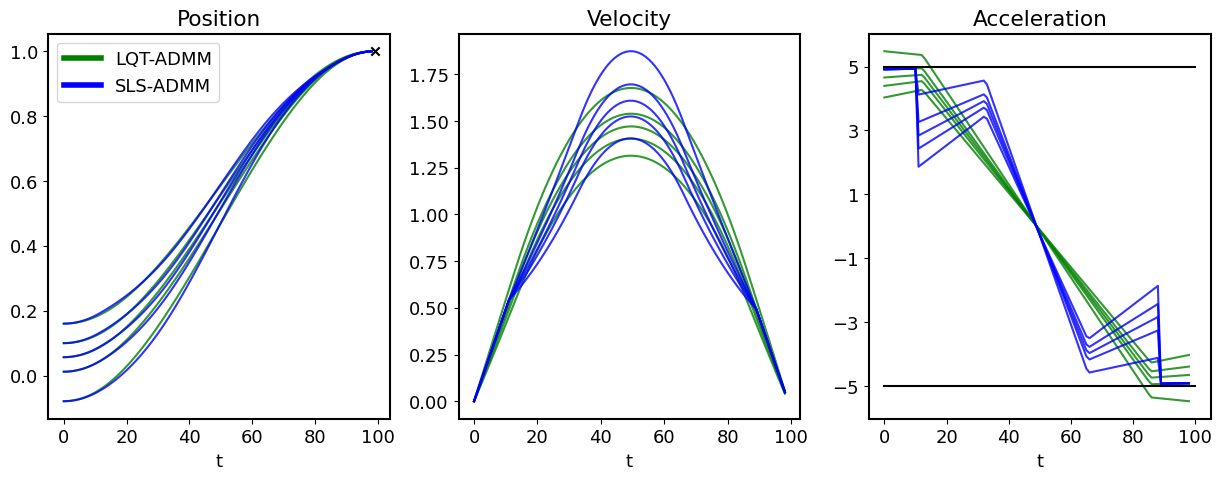

In [38]:
colors = ["g", "b", "orange"]
fig,axes_ = plt.subplots(nrows=x_dim, ncols=3, figsize=(15,5*x_dim))
if x_dim == 1: axes_ = [axes_]

# vias = [via1, via2, via1_, via2_]
# times = [via_time1, via_time2, via_time1_, via_time2_ ]
titles = ["Position", "Velocity", "Acceleration"]
ylabels = np.array([[r"$x$",r"$\dot{x}$",r"$\ddot{x}$"],[r"$y$",r"$\dot{y}$",r"$\ddot{y}$"]])
label =[r"$V_1$", r"$V_2$",r"$VN_1$",r"$VN_2$",]
markers = ["_", "_", "_", "_"]
colors_markers = ["r", "r", "magenta", "magenta"]

changed = True
lw = 15
for dim,axes in enumerate(axes_):

    axes[0].scatter(horizon-1, x_final_target[0],marker="x", color="k")
    logs = np.concatenate((x_logs, u_logs), -1)
    for i in range(3):
        for cnt,log in enumerate(logs):
            axes[i].plot(log[:, :-1, i*x_dim+dim].T,color=colors[cnt], alpha=0.8)  
        # axes[i].set_ylabel(ylabels[dim,i])
        axes[i].set_xlabel("t")
        axes[i].set_title(titles[i])
# axes[0].set_ylim([-1,1])

axes[2].plot([0,N], [upper]*2, "k")
axes[2].plot([0,N], [lower]*2, "k")
axes[2].set_yticks(np.arange(-5, 6, 2))
# axes_[1,2].plot([0,101], [upper]*2, "k")
# axes_[1,2].plot([0,101], [lower]*2, "k")

# from matplotlib.lines import Line2D
from matplotlib.lines import Line2D  
custom_lines = [Line2D([0], [0], color=colors[i], lw=4) for i in range(len(colors))]

axes[0].legend(custom_lines, ['LQT-ADMM', 'SLS-ADMM'])
# for i in range(3):
#     axes[i].xaxis.set_label_coords(1.03, 0.03)
# plt.savefig(r"C:\Users\hakan\Papers\sls\admm_images\control_bounds.pdf", format="pdf", bbox_inches='tight')